In [1]:
# Written by Christopher Straub
# inspired from Francois Fleuret <francois@fleuret.org> code (practical3)

import math
from torch import empty
from torch import set_grad_enabled
import numpy as np
import dlc_practical_prologue as prologue

set_grad_enabled(False)

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    def backward(self, *gradwrtoutput): 
        raise NotImplementedError
    def param(self): 
        return []

In [3]:
class Linear(Module):
    def __init__(self,input_size, hidden_size):
        super().__init__()
        epsilon = 1e-6
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.weights=empty(input_size, hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#(empty(input_size, hidden_size).normal_(0,epsilon))#Weight
        self.biais=empty(hidden_size).uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#( empty(hidden_size).normal_(0,epsilon)) #bias

    def sigma(self,x):
        out = 0
        if len(x.size())>1:
            
            out = x.mm(self.weights)+self.biais.view(1,-1)*(empty(x.size(0),self.hidden_size).zero_().add(1))
        else : 
            out = self.weights.t().mv(x)+self.biais
        return out 
    def dsigma(self,x):
        out = 0
        if len(x.size())>1:
            out = x.mm(self.weights.T)
        else : 
            out = self.weights().mv(x)
            
        return out
    def param(self):
        return [self.weights,self.biais]
    def set_param(self,new_w,new_b):
        self.weights= new_w
        self.biais = new_b
        

In [4]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
    def sigma(self,x):
        return x.tanh()
    def dsigma(self,x):
        return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

In [5]:
class MSE(Module):  
    def __init__(self):
        super().__init__()
    def sigma(self,x,y):

        
        return (x - y).pow(2).sum()
    def dsigma(self,x,y):
        #if len(y.size())>1:
        #    y = y.argmax(0)
            
        return 2*(x - y)
    

In [6]:
class logMSE(Module): 
    def __init__(self):
        super().__init__()
    def sigma(self,x,y):

        
        return (x - y).pow(2).sum().log().mul(-1)
    def dsigma(self,x,y):
        #if len(y.size())>1:
        #    y = y.argmax(0)
            
        return 2*(x - y)*((x - y).pow(2).sum()).pow(-1)

In [7]:
class Loss(Module):  
    def __init__(self,loss,net):
        super().__init__()
        self.net = net
        self.loss = loss
        self.acc_loss=0
        self.nb_train_errors=0
    def sigma(self,x,y):
        return self.loss.sigma(x,y)
    def dsigma(self,x,y):
        return self.dloss.sigma(x,y)
    def assign(self, net):
        self.net =net 
    #def prediction(self, *input):
    #    return self.loss.sigma(self.net.forward_value)
    
    def backward(self,*gradwrtoutput): 
        x,s = self.net.forward(self.net.train)
    
        #print(self.net.train_target.size())
        for n in range(self.net.num_sample):
            x2 = x[-1][n]
            pred = x2.argmax().item()
            #print('n',pred)
            if self.net.train_target[n][ pred] < 0.5:
                self.nb_train_errors +=  1
        
            self.acc_loss+=  self.loss.sigma(x2, self.net.train_target[n])
        
        gradwrtoutput = [self.net.train_target,[x,s],self.loss]
        self.net.backward(*gradwrtoutput)

In [8]:
class CrossEntropy(Module):
    def __init__(self):
        super().__init__()
    def sigma(self,x,y):
        y_=y.argmax().item()
        return -(x[y_].exp().div(x.exp().sum()).log())
    def dsigma(self,x,y):
        y_=y.argmax().item()
        out= x.exp().div(x.exp().sum())
        out[y_]=1-x[y_].exp().div(x.exp().sum())
        return out 
   

In [9]:
class Relu( Module ) :
    def __init__(self):
        super().__init__()
    def sigma(self,x):
        return x.max(empty(x.size()).zero_())
    def dsigma(self,x):
        out = empty(x.size()).zero_()
        out[x>0]=1
        return out
   

In [10]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.Parameters = []
        self.Activation = []
        self.dl_dw = []
        self.dl_db = []
        self.train = []
        self.train_target = []
        self.forward_value=[]
        self.num_sample = 0
    def forward(self,*input):
        train_input=input[0]
        x = train_input
        out_s = []
        out_x = [train_input]
        for i in range(len(self.Activation)):
            s = self.Parameters[i].sigma(x)
            out_s.append(s)
            x = self.Activation[i].sigma(s)
            out_x.append(x)
        return [out_x,out_s]

    def backward(self,*gradwrtoutput):
        train_target,layer_output,Loss = gradwrtoutput
        dl_dw = self.dl_dw
        dl_db = self.dl_db
        N=len(dl_dw)
        x,s=layer_output
        x0 = x[0]
        dl_dx2 = Loss.dsigma(x[N], train_target)
        #print('dl_dx_2',dl_dx2.size())
        #print('s[N-1]',s[N-1].size())
        #print(self.Activation[N-1])
        dl_ds2 = self.Activation[N-1].dsigma(s[N-1]) * dl_dx2
        dl_dw2 = dl_dw[N-1]
        dl_db2 = dl_db[N-1]
        #print('dl_ds2',dl_ds2.size())
        #print('x[N-1]',x[N-1].size())
        
        #print('dl_dw2',dl_dw2.size())
        dl_dw2.add_( x[N-1].view(x[N-1].size(0),x[N-1].size(1),1).matmul(dl_ds2.view(dl_ds2.size(0),1,dl_ds2.size(1))))
        dl_db2.add_(dl_ds2)
        out_dl_dw = [dl_dw2]
        out_dl_db = [dl_db2]

        for i in range(1,N,1):

            dl_dx1 = self.Parameters[N-i].dsigma(dl_ds2) #c'est pas très jolie mais par Parameters je veux dire la fonction devrivant les poids de la couche cache (ici linear)
            dl_ds1 = self.Activation[N-1-i].dsigma(s[N-1-i]) * dl_dx1
            dl_dw1 = dl_dw[N-1-i]
            dl_db1 = dl_db[N-1-i]
             
            dl_dw1.add_(x[N-1-i].view(x[N-1-i].size(0),x[N-1-i].size(1),1).matmul(dl_ds1.view(dl_ds1.size(0),1,dl_ds1.size(1))))
            dl_db1.add_(dl_ds1)
            out_dl_dw.insert(0,dl_dw1)
            out_dl_db.insert(0,dl_db1)
            dl_ds2 = dl_ds1
        self.dl_dw,self.dl_db = out_dl_dw,out_dl_db
    def param(self):
        return self.Parameters
    def init(self,new_Parameters,new_Activation):
        self.Parameters= new_Parameters
        self.Activation = new_Activation

    def set_param(self,num_layer,new_w,new_b):
        self.Parameters[num_layer].set_param(new_w,new_b)
    def get_grad(self,num_layer):
        return [self.dl_dw[num_layer],self.dl_db[num_layer]]
    def zero_grad(self):
        for dw in self.dl_dw:
            dw.zero_()
        for db in self.dl_db:
            db.zero_()

    def assign(self, train,train_target):
        
        if len(train_input.size())>1 : 
            self.train = train
            self.train_target = train_target
            self.num_sample = train.size(0)
            self.dl_dw = [empty(self.num_sample,p.param()[0].size(0),p.param()[0].size(1)) for p in self.Parameters]
            self.dl_db = [empty(self.num_sample,p.param()[1].size(0)) for p in self.Parameters]
        else : 
            self.num_sample = 1
            self.train = train
            self.train_target = train_target
            self.dl_dw = [empty(p.param()[0].size()) for p in self.Parameters]
            self.dl_db = [empty(p.param()[1].size()) for p in self.Parameters]


In [11]:
class Sequential(Module):
    def __init__(self,*layers):
        super().__init__()
        self.layers = layers 
    def init_net(self):
        net = Net()
        new_Parameters=[]
        new_Activation=[]
        i = 0
        for layer in self.layers : 
            if np.mod(i,2)==0:
                new_Parameters.append(layer)
            else : 
                new_Activation.append(layer)
            i=i+1
        net.init(new_Parameters,new_Activation)
        return net 

In [12]:
def one_hot(a):
    num_class = a.max()+1
    N=a.size(0)
    out = empty(N,num_class).zero_()
    for i in range(N) :
        out[i][a[i]]=1 
    return out 
        

In [13]:
def generate_disc_set(nb):
    input = empty(nb, 2).uniform_(-1, 1)
    target = input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    
    return input, one_hot(target)

In [14]:


train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

mini_batch_size = 100


nb_classes = train_target.size(1)
nb_train_samples = train_input.size(0)

zeta = 0.90



nb_hidden = 25
eta = 1e-1 / nb_train_samples
epsilon = 1e-6


net = Sequential(Linear (train_input.size(1),(nb_hidden)),Tanh(),Linear( nb_hidden,nb_hidden),Linear( nb_hidden,nb_hidden),Tanh(),Linear( nb_hidden,nb_hidden),Tanh(),Linear( nb_hidden,nb_classes),Tanh()).init_net()

loss = Loss(MSE(),net)


nb_epochs = 1000

for e in range(nb_epochs):
    for b in range(0, train_input.size(0), mini_batch_size):

    # Back-prop

        net.assign(train_input.narrow(0, b, mini_batch_size),train_target.narrow(0, b, mini_batch_size))
        net.zero_grad()
        loss.backward()

    # Gradient step
   
    for i in range(len(net.param())):
        dl_dw ,dl_db = net.get_grad(i)
        new_w=net.param()[i].param()[0]-eta * dl_dw.sum(0)  #en faisant que n(t,b) sot séquentielle
        new_b=net.param()[i].param()[1]-eta* dl_db.sum(0) 
        net.set_param(i,new_w,new_b)

    
    # Test error

    nb_test_errors = 0
    
    for n in range(test_input.size(0)):
        x,s = net.forward(test_input[n])
        #print('test_input',test_input[n])
        x2 = x[-1]
        pred = x2.argmax().item()
        #print('n',n,'x2',x2)
        #print(pred)
        if test_target[n][ pred] < 0.5:
            nb_test_errors +=  1
       

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(e,
                  loss.acc_loss,
                  (100 * loss.nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
    loss.nb_train_errors  = 0
    loss.acc_loss=0

0 acc_train_loss 915.18 acc_train_error 47.70% test_error 42.50%
1 acc_train_loss 877.22 acc_train_error 47.00% test_error 41.60%
2 acc_train_loss 842.71 acc_train_error 46.10% test_error 40.60%
3 acc_train_loss 811.36 acc_train_error 45.40% test_error 39.60%
4 acc_train_loss 782.92 acc_train_error 44.50% test_error 38.80%
5 acc_train_loss 757.15 acc_train_error 43.70% test_error 38.20%
6 acc_train_loss 733.81 acc_train_error 42.80% test_error 38.30%
7 acc_train_loss 712.68 acc_train_error 42.20% test_error 37.80%
8 acc_train_loss 693.56 acc_train_error 42.00% test_error 37.00%
9 acc_train_loss 676.24 acc_train_error 41.80% test_error 36.70%
10 acc_train_loss 660.57 acc_train_error 41.20% test_error 37.00%
11 acc_train_loss 646.38 acc_train_error 41.50% test_error 37.10%
12 acc_train_loss 633.52 acc_train_error 41.50% test_error 37.10%
13 acc_train_loss 621.86 acc_train_error 41.90% test_error 36.80%
14 acc_train_loss 611.29 acc_train_error 42.00% test_error 36.50%
15 acc_train_loss 60

In [35]:
from torch import save
from torch import load
out = {}
i=0
s = 'W'
b = 'b'
for p in net.param():
    out[s+str(i)]=p.param()[0]
    out[b+str(i)]=p.param()[1]
    i+=1
save(out,'./project_parameters')
a = load('./project_parameters')

In [51]:
save(net,'./project_net_1')

In [50]:
# avec comme fonction d'activation que des tanh 
out

{'W0': tensor([[ 0.3659, -0.1500,  0.5427, -0.6216,  0.6553,  0.2846, -0.5727, -0.5874,
           0.5622,  0.7117, -0.0079, -0.3668,  0.3835,  0.2823, -0.0958,  0.5741,
           0.6487,  0.2086,  0.4801, -0.7943, -0.3232,  0.0906,  0.1508, -0.0892,
           0.2525],
         [ 0.2225, -0.7780,  0.2290, -0.0507, -0.4791, -0.0096, -0.1695, -0.3789,
          -0.6975,  0.5830, -0.3744,  0.0786,  0.6671, -0.0936, -0.4522, -0.7636,
           0.1874, -0.3889,  0.1146,  0.2588, -0.1873,  0.4424, -0.0700, -0.2693,
          -0.4674]]),
 'b0': tensor([ 0.2061, -0.5064,  0.1355, -0.1795,  0.5061, -0.3544, -0.4145, -0.0288,
         -0.5196,  0.2067, -0.2317,  0.2757,  0.5193,  0.4247, -0.1066,  0.4948,
         -0.4259, -0.7062, -0.1180, -0.5845, -0.5595,  0.1608,  0.6400, -0.2807,
         -0.0281]),
 'W1': tensor([[-1.4850e-01, -4.8938e-03,  8.9508e-02, -5.3056e-02,  1.5509e-01,
          -2.0965e-01, -2.6175e-02, -1.1194e-01,  1.8299e-01,  1.5803e-01,
           1.7523e-01,  1.8920e-01,

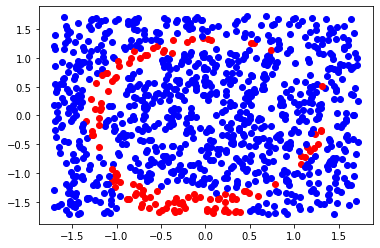

In [48]:
import matplotlib.pyplot as plt
for n in range(test_input.size(0)):
        x,s = net.forward(test_input[n])
        #print('test_input',test_input[n])
        x2 = x[-1]
        pred = x2.argmax().item()
        #print('n',n,'x2',x2)
        #print(pred)
        #print(test_input[n][0].item())
        if test_target[n][ pred] < 0.5:
            
            plt.scatter(test_input[n][0].item(),test_input[n][1].item(),c='red')
            #nb_test_errors +=  1
        else : 
            plt.scatter(test_input[n][0].item(),test_input[n][1].item(),c='blue')
            #plt.scatter(test_input[n],'b')
plt.show()

In [17]:
# à faire implémenter l'initialisation des paramètres comme expliquer dans le cours .
# que signifie 3 couche caché avec 25 unité ? 
# comment faire en sorte que le predict soit bien ? 
# vaut mieux avoir une sortie a savoir une valeur et voir si elle se rapproche de la valeur recherché ? 
# faire un plot avec avec un entrainement d'un ensemble de valeur dans un carré uniforme et voir quel sont les valeur correctment classifié 
# est ce que j'utilise vrm la puissance des tenseur ??? 

In [53]:
b = load('./project_net_1')